# Entrega 6 - Extração de Dados Estruturados
## Ciência de Dados Aplicada ao Direito II

**Objetivo:** Extrair informações estruturadas dos casos de crédito consignado (já filtrados pela Entrega 5)

### Fluxo de Trabalho:
1. **Entrega 5** → Filtra casos de crédito consignado do dataset completo
2. **Entrega 6** → Extrai informações detalhadas APENAS dos casos filtrados

### Campos Extraídos:
- `cd_atendimento`: ID do caso
- `nome_empresa`: Nome da empresa no polo passivo
- `cnpj`: CNPJ válido (14 dígitos)
- `valor_causa`: Valor da causa em reais
- `dt_distribuicao`: Data de distribuição (YYYY-MM-DD)
- `tipo_vara`: JE (Juizado Especial) ou G1 (Vara Comum)
- `uf`: Unidade Federativa

## Sumário Executivo

### Como Usar Este Notebook

1. **Instale as dependências** (célula 2 - opcional se já tiver instalado)
2. **Execute todas as células em ordem** 
3. **Resultado:** Arquivo `output.xlsx` com 7 colunas (requisito do roteiro)
4. **Opcional:** Execute seção 10.1 para gerar `output_expandido.xlsx` com análise de danos morais/materiais

### Entrada de Dados

O notebook carrega automaticamente `./dataset_filtrado.xlsx` (casos de crédito consignado já filtrados).
Se não existir, tenta fallbacks alternativos.

### Saídas

- `output.xlsx`: 7 colunas do roteiro oficial
- `output_expandido.xlsx`: 13 colunas incluindo danos morais/materiais (opcional)

---

In [34]:
# Imports
import re
import unicodedata
import pandas as pd
import numpy as np
from typing import List, Tuple, Dict
from unidecode import unidecode
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

print("Bibliotecas importadas com sucesso")

Bibliotecas importadas com sucesso


In [35]:
# (opcional) instalar deps no ambiente atual, se faltar algo
# !pip install -q "pandas>=2.0" "numpy>=1.24" "openpyxl>=3.1" "jupyter>=1.0" \
#                "unidecode>=1.3" "matplotlib>=3.8" "seaborn>=0.13"

## 1. Carregamento de Dados

Carrega o dataset completo e filtra apenas os casos de crédito consignado identificados pela Entrega 5.

*Essa parte do código é somente para aplicar o filtro da entrega 5 no db inteiro, por isso está comentada. O `dataset_filtrado.xlsx` é o produto disso.*

## 2. Funções Auxiliares

Funções de limpeza e normalização de texto.

In [36]:
# LINHA DE SELEÇÃO DO INPUT

print("="*80)
print("CARREGAMENTO DE DADOS")
print("="*80)

# Prioriza dataset_filtrado.xlsx no mesmo diretório do notebook
try:
    df = pd.read_excel("./dataset_filtrado.xlsx")
    print(f"\nDataset carregado: ./dataset_filtrado.xlsx")
    print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
    print("Dataset pronto para extração!")
    
except FileNotFoundError:
    # Fallback: tenta no diretório pai
    try:
        df = pd.read_excel("../dataset_filtrado.xlsx")
        print("Usando fallback: ../dataset_filtrado.xlsx")
        print(f"Dimensões: {df.shape[0]} linhas x {df.shape[1]} colunas")
        
    except FileNotFoundError:
        # Fallback final: tenta carregar do dataset original com filtro da Entrega 5
        print("\nAVISO: dataset_filtrado.xlsx não encontrado!")
        print("Tentando carregar e filtrar dataset original...")
        
        try:
            INPUT_CSV = "../data/dataset_clinica20252.csv"
            df_completo = pd.read_csv(INPUT_CSV, sep="|")
            
            ENTREGA5_OUTPUT = "../entrega5/output.xlsx"
            df_filtrados = pd.read_excel(ENTREGA5_OUTPUT)
            
            cd_list = df_filtrados['cd_atendimento'].astype(str).tolist()
            df = df_completo[df_completo['cd_atendimento'].astype(str).isin(cd_list)].copy()
            
            print(f"Dataset filtrado dinamicamente: {df.shape[0]} linhas x {df.shape[1]} colunas")
            
        except Exception as e:
            print(f"\nERRO: Não foi possível carregar nenhum dataset!")
            print(f"Detalhes: {e}")
            raise

print("="*80)

CARREGAMENTO DE DADOS

Dataset carregado: ./dataset_filtrado.xlsx
Dimensões: 8557 linhas x 6 colunas
Dataset pronto para extração!

Dataset carregado: ./dataset_filtrado.xlsx
Dimensões: 8557 linhas x 6 colunas
Dataset pronto para extração!


### Dataset Filtrado Salvo

O arquivo `dataset_filtrado.xlsx` contém:
- **TODOS os casos** de crédito consignado identificados pela Entrega 5
- **TODAS as colunas** originais do dataset
- Pronto para análises futuras (sem precisar reprocessar o filtro)

Este arquivo será a base para todas as próximas análises!

In [37]:
def strip_accents(s: str) -> str:
    """Remove acentos de uma string."""
    if not isinstance(s, str): 
        return ""
    return "".join(c for c in unicodedata.normalize("NFD", s) 
                   if unicodedata.category(c) != "Mn")

def clean_text(s: str) -> str:
    """Limpa e normaliza texto."""
    s = (s or "").replace("\n", " ")
    return re.sub(r"\s+", " ", s).strip()

def limpar_para_excel(texto):
    """Remove caracteres de controle que causam problemas no Excel."""
    if not isinstance(texto, str):
        return texto
    # Remove caracteres de controle (0x00-0x1F exceto tab, newline, carriage return)
    return re.sub(r'[\x00-\x08\x0B-\x0C\x0E-\x1F]', '', texto)

# Constantes
UF_LIST = set("AC AL AP AM BA CE DF ES GO MA MT MS MG PA PB PR PE PI RJ RN RS RO RR SC SP SE TO".split())

print("✓ Funções auxiliares definidas")

✓ Funções auxiliares definidas


## 3. Extração de CNPJ

Validação de CNPJs e busca com validação de dígitos verificadores.

In [38]:
def cnpj_is_valid(cnpj_digits: str) -> bool:
    """Valida dígitos verificadores do CNPJ (14 dígitos)."""
    if len(cnpj_digits) != 14 or len(set(cnpj_digits)) == 1:
        return False
    
    nums = [int(x) for x in cnpj_digits]
    
    # Valida os dois dígitos verificadores
    for i in [12, 13]:
        pesos = [5,4,3,2,9,8,7,6,5,4,3,2] if i == 12 else [6,5,4,3,2,9,8,7,6,5,4,3,2]
        soma = sum(a * b for a, b in zip(nums[:i], pesos))
        dig = 11 - (soma % 11)
        dig = 0 if dig >= 10 else dig
        if nums[i] != dig: 
            return False
    
    return True


def find_cnpjs_pos(text: str) -> List[Tuple[str, int]]:
    """Encontra CNPJs válidos no texto com suas posições."""
    out = []
    pattern = r"\b\d{2}\.?\d{3}\.?\d{3}/?\d{4}-?\d{2}\b"
    
    for m in re.finditer(pattern, text):
        digits = re.sub(r"\D", "", m.group(0))
        if len(digits) == 14 and cnpj_is_valid(digits):
            out.append((digits, m.start()))
    
    return out


print("✓ Funções de validação de CNPJ definidas")

✓ Funções de validação de CNPJ definidas


## 4. Extração de Nome de Empresa

Estratégia simplificada sem regex complexa:
1. Procura "BANCO" ou sufixo societário (S.A, LTDA, etc.)
2. Captura APENAS palavras com letras
3. Para quando encontrar: números, CNPJ, endereço, etc.

In [39]:
def extract_company_name_simple(text: str) -> Tuple[str, int, int]:
    """
    Extrai nome da empresa de forma simplificada.
    
    Retorna: (nome_empresa, posicao_inicio, posicao_fim) ou ("vazio", -1, -1)
    """
    T = clean_text(text).upper()
    
    # Palavras que indicam FIM do nome da empresa
    STOP_WORDS = {
        'INSCRITO', 'INSCRITA', 'CNPJ', 'CPF', 'SITO', 'SITA',
        'ENDERECO', 'ENDEREÇO', 'RUA', 'AVENIDA', 'PRACA', 'PRAÇA',
        'NUMERO', 'NÚMERO', 'CEP', 'BAIRRO', 'CIDADE', 'ESTADO',
        'REPRESENTADO', 'REPRESENTADA', 'ADVOGADO', 'ADVOGADA',
        'QUALIFICADO', 'QUALIFICADA', 'BRASILEIRO', 'BRASILEIRA'
    }
    
    # Sufixos societários válidos
    SUFFIXES = ['S.A.', 'S.A', 'S/A', 'LTDA', 'LTDA.', 'EIRELI', 'ME', 'EPP']
    
    # Procura "BANCO" no texto
    banco_pos = T.find('BANCO')
    if banco_pos == -1:
        # Se não tem BANCO, procura por sufixo societário
        for suffix in SUFFIXES:
            if suffix in T:
                suffix_pos = T.find(suffix)
                start = max(0, suffix_pos - 100)
                trecho = T[start:suffix_pos + len(suffix)]
                words = trecho.split()[-6:]
                nome = ' '.join(words).strip()
                return (nome, start, suffix_pos + len(suffix))
        
        return ("vazio", -1, -1)
    
    # A partir de "BANCO", captura palavras seguintes
    start_pos = banco_pos
    trecho = T[banco_pos:]
    palavras = trecho.split()
    
    nome_parts = []
    last_pos = banco_pos
    
    for i, palavra in enumerate(palavras):
        palavra_limpa = palavra.strip('.,;:()')
        
        # PARA se encontrar palavra-chave de parada
        if palavra_limpa in STOP_WORDS:
            break
        
        # PARA se encontrar números (exceto em sufixos)
        if any(char.isdigit() for char in palavra_limpa):
            if not any(s in palavra for s in ['S.A', 'S/A']):
                break
        
        # PARA se tiver mais de 6 palavras
        if i > 6:
            break
        
        nome_parts.append(palavra)
        last_pos = banco_pos + trecho.find(palavra) + len(palavra)
        
        # PARA se encontrou sufixo societário
        if any(s in palavra for s in SUFFIXES):
            break
    
    if nome_parts:
        nome = ' '.join(nome_parts).strip('.,;: ')
        return (nome, start_pos, last_pos)
    
    return ("vazio", -1, -1)


def find_company_spans(text: str) -> List[Tuple[str, int, int]]:
    """Retorna lista com apenas 1 empresa (a primeira encontrada)."""
    nome, start, end = extract_company_name_simple(text)
    
    if nome != "vazio":
        return [(nome, start, end)]
    
    return []


print("✓ Funções de extração de empresa definidas")

✓ Funções de extração de empresa definidas


## 5. Associação Empresa + CNPJ

Retorna APENAS 1 CNPJ por caso, priorizando proximidade ao nome da empresa.

In [40]:
def pick_company_and_cnpjs_v3(text: str, win_after=400, win_before=200) -> Tuple[str, str]:
    """
    Extrai empresa e CNPJ com proximidade.
    
    - Retorna APENAS 1 CNPJ (não uma lista)
    - Prioriza CNPJ mais próximo ao nome da empresa
    - Janela: 400 chars depois, 200 antes
    
    Retorna: (nome_empresa, cnpj_string)
    """
    T = clean_text(text)
    companies = find_company_spans(T)
    cnpjs_pos = find_cnpjs_pos(T)
    
    def cnpj_mais_proximo(start, end):
        """Retorna o CNPJ MAIS PRÓXIMO ao span da empresa."""
        candidatos = []
        for cnpj, pos in cnpjs_pos:
            if (start - win_before) <= pos <= (end + win_after):
                # Calcula distância (prioriza CNPJs após o nome)
                if pos >= start:
                    distancia = pos - end
                else:
                    distancia = (start - pos) * 2  # Penaliza CNPJs antes
                
                candidatos.append((cnpj, distancia))
        
        if candidatos:
            candidatos.sort(key=lambda x: x[1])
            return candidatos[0][0]
        
        return None
    
    # 1) Tenta associar por proximidade
    for name, s, e in companies:
        cnpj_proximo = cnpj_mais_proximo(s, e)
        if cnpj_proximo:
            return name, cnpj_proximo
    
    # 2) Fallback: retorna PRIMEIRO CNPJ válido
    if cnpjs_pos:
        primeiro_cnpj = cnpjs_pos[0][0]
        if companies:
            return companies[0][0], primeiro_cnpj
        return "vazio", primeiro_cnpj
    
    return "vazio", "vazio"


print("✓ Função de associação empresa+CNPJ definida")

✓ Função de associação empresa+CNPJ definida


## 6. Extração de Valor da Causa

Procura valores no formato brasileiro (1.234,56) próximos ao label "valor da causa".

In [41]:
def extract_valor_causa(text: str) -> float:
    """Extrai valor da causa em reais."""
    T = clean_text(text)
    t_lower = strip_accents(T).lower()
    
    # Limites razoáveis para ações de crédito consignado
    MIN_VALOR = 100.0
    MAX_VALOR = 10_000_000.0
    
    # Padrão: valores no formato brasileiro (1.234,56 ou R$ 1.234,56)
    pattern = r"R?\$?\s*(\d{1,3}(?:\.\d{3})*,\d{2}|\d+,\d{2})"
    
    # 1) Primeiro tenta próximo a "valor da causa"
    if "valor" in t_lower and "causa" in t_lower:
        pos = t_lower.find("valor")
        trecho = T[max(0, pos-150):pos+150]
        
        valores = []
        for match in re.finditer(pattern, trecho):
            num_str = match.group(1)
            valor = float(num_str.replace(".", "").replace(",", "."))
            if MIN_VALOR <= valor <= MAX_VALOR:
                valores.append(valor)
        
        if valores:
            return max(valores)
    
    # 2) Busca em todo texto
    valores = []
    for match in re.finditer(pattern, T):
        num_str = match.group(1)
        valor = float(num_str.replace(".", "").replace(",", "."))
        if MIN_VALOR <= valor <= MAX_VALOR:
            valores.append(valor)
    
    return max(valores) if valores else 0.0


print("✓ Função de extração de valor definida")

✓ Função de extração de valor definida


## 7. Extração de Data de Distribuição

Procura data próxima a "distribuição" ou "autuação" em formatos DD/MM/YYYY ou YYYY-MM-DD.

## 6.1. Extração de Valores de Danos Morais e Materiais

Busca valores pedidos a título de danos morais e materiais, com flags para qualificadores ("não inferior", "em dobro", "até").

In [42]:
def extract_valores_morais_materiais(text: str) -> Dict:
    """
    Busca janelas ±100 chars ao redor de 'danos morais' e 'danos materiais',
    captura valores monetários pt-BR e flags ('não inferior', 'em dobro', 'até').
    
    Retorna:
      {
        'valor_moral': float,
        'valor_material': float,
        'has_minimo': bool,     # 'não inferior'
        'has_em_dobro': bool,
        'has_ate': bool,
        'evidencia': str        # recorte curto do trecho
      }
    """
    T = clean_text(text)
    t_lower = strip_accents(T).lower()
    
    # Padrão para valores em formato brasileiro
    pattern_valor = r"R?\$?\s*(\d{1,3}(?:\.\d{3})*,\d{2}|\d+,\d{2})"
    
    # Limites razoáveis
    MIN_VALOR = 100.0
    MAX_VALOR = 10_000_000.0
    
    resultado = {
        'valor_moral': 0.0,
        'valor_material': 0.0,
        'has_minimo': False,
        'has_em_dobro': False,
        'has_ate': False,
        'evidencia': ''
    }
    
    # Busca danos morais
    if 'danos morais' in t_lower or 'dano moral' in t_lower:
        # Encontra posição
        pos = t_lower.find('danos morais') if 'danos morais' in t_lower else t_lower.find('dano moral')
        
        # Janela de ±100 chars
        inicio = max(0, pos - 100)
        fim = min(len(T), pos + 100)
        trecho = T[inicio:fim]
        trecho_lower = t_lower[inicio:fim]
        
        # Busca valores
        valores_morais = []
        for match in re.finditer(pattern_valor, trecho):
            num_str = match.group(1)
            valor = float(num_str.replace(".", "").replace(",", "."))
            if MIN_VALOR <= valor <= MAX_VALOR:
                valores_morais.append(valor)
        
        if valores_morais:
            resultado['valor_moral'] = max(valores_morais)
            
        # Verifica flags
        if 'nao inferior' in trecho_lower or 'não inferior' in trecho_lower:
            resultado['has_minimo'] = True
        if 'em dobro' in trecho_lower:
            resultado['has_em_dobro'] = True
        if 'até' in trecho_lower or 'ate' in trecho_lower:
            resultado['has_ate'] = True
            
        # Salva evidência (recorte de até 150 chars)
        evidencia_moral = trecho[:150].strip()
        if len(trecho) > 150:
            evidencia_moral += "..."
        resultado['evidencia'] = evidencia_moral
    
    # Busca danos materiais
    if 'danos materiais' in t_lower or 'dano material' in t_lower:
        pos = t_lower.find('danos materiais') if 'danos materiais' in t_lower else t_lower.find('dano material')
        
        inicio = max(0, pos - 100)
        fim = min(len(T), pos + 100)
        trecho = T[inicio:fim]
        trecho_lower = t_lower[inicio:fim]
        
        valores_materiais = []
        for match in re.finditer(pattern_valor, trecho):
            num_str = match.group(1)
            valor = float(num_str.replace(".", "").replace(",", "."))
            if MIN_VALOR <= valor <= MAX_VALOR:
                valores_materiais.append(valor)
        
        if valores_materiais:
            resultado['valor_material'] = max(valores_materiais)
            
        # Atualiza flags (pode ter em ambos os trechos)
        if 'nao inferior' in trecho_lower or 'não inferior' in trecho_lower:
            resultado['has_minimo'] = True
        if 'em dobro' in trecho_lower:
            resultado['has_em_dobro'] = True
        if 'até' in trecho_lower or 'ate' in trecho_lower:
            resultado['has_ate'] = True
            
        # Se não tinha evidência ainda, adiciona a dos materiais
        if not resultado['evidencia']:
            evidencia_mat = trecho[:150].strip()
            if len(trecho) > 150:
                evidencia_mat += "..."
            resultado['evidencia'] = evidencia_mat
    
    return resultado


print("✓ Função de extração de valores morais/materiais definida")

✓ Função de extração de valores morais/materiais definida


In [43]:
def extract_dt_distribuicao(text: str) -> str:
    """Extrai data de distribuição no formato YYYY-MM-DD."""
    t = strip_accents(clean_text(text)).lower()
    
    # Padrões de data
    pattern_iso = r"(20\d{2})-(0[1-9]|1[0-2])-(0[1-9]|[12]\d|3[01])"
    pattern_br = r"(0[1-9]|[12]\d|3[01])[/\-](0[1-9]|1[0-2])[/\-](20\d{2})"
    
    # 1) Procura próximo a "distribuição" ou "autuação"
    for keyword in ['distribuicao', 'distribuido', 'autuacao', 'autuado']:
        pos = t.find(keyword)
        if pos != -1:
            trecho = t[max(0, pos-100):pos+100]
            
            # Tenta ISO
            match = re.search(pattern_iso, trecho)
            if match:
                return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
            
            # Tenta BR
            match = re.search(pattern_br, trecho)
            if match:
                dd, mm, y = match.group(1), match.group(2), match.group(3)
                return f"{y}-{mm.zfill(2)}-{dd.zfill(2)}"
    
    # 2) Fallback: primeira data ISO
    match = re.search(pattern_iso, t)
    if match:
        return f"{match.group(1)}-{match.group(2)}-{match.group(3)}"
    
    # 3) Fallback: primeira data BR
    match = re.search(pattern_br, t)
    if match:
        dd, mm, y = match.group(1), match.group(2), match.group(3)
        return f"{y}-{mm.zfill(2)}-{dd.zfill(2)}"
    
    return ""


print("✓ Função de extração de data definida")

✓ Função de extração de data definida


## 8. Extração de Tipo de Vara e UF

Funções para classificar tipo de vara e extrair UF.

In [44]:
def classify_tipo_vara(text: str) -> str:
    """Classifica o tipo de vara: JE (Juizado Especial) ou G1 (Vara Comum)."""
    t = strip_accents(clean_text(text)).lower()
    if "juizado especial" in t or "jecc" in t:
        return "JE"
    return "G1"


def extract_uf(text: str) -> str:
    """Extrai a UF (estado) do texto."""
    tokens = re.findall(r"\b[A-Z]{2}\b", clean_text(text).upper())
    for tk in tokens:
        if tk in UF_LIST:
            return tk
    return ""


print("✓ Funções de tipo de vara e UF definidas")

✓ Funções de tipo de vara e UF definidas


## 9. Função Principal de Extração

Processa todos os casos e extrai os 7 campos estruturados.

## 9.1. Extração Expandida (com Danos Morais e Materiais)

Função adicional que extrai os valores de danos morais/materiais para análise.

In [45]:
def extrair_dados_expandido(df: pd.DataFrame, output_path: str = "output_expandido.xlsx") -> pd.DataFrame:
    """
    Extrai todos os campos INCLUINDO valores de danos morais e materiais.
    
    Este DataFrame é para análise interna e contém colunas adicionais:
    - valor_moral, valor_material, has_minimo, has_em_dobro, has_ate, evidencia_pedidos
    
    Retorna: DataFrame expandido + salva em Excel
    """
    print("\n" + "="*80)
    print("EXTRAÇÃO EXPANDIDA (com danos morais/materiais)")
    print("="*80)
    
    # Carrega colunas de texto
    qual = df.get("ds_Qualificacao", "").astype(str)
    fatos = df.get("ds_fatos", "").astype(str)
    pedidos = df.get("ds_Pedidos", "").astype(str)
    acao = df.get("ds_Acao_Judicial", "").astype(str)
    
    # Função para extrair empresa e CNPJ
    def extrair_cnpj_empresa(row):
        nome, cnpj = pick_company_and_cnpjs_v3(row['ds_Qualificacao'])
        if cnpj != "vazio":
            return nome, cnpj
        texto_completo = f"{row['ds_Qualificacao']} {row['ds_fatos']} {row['ds_Pedidos']} {row['ds_Acao_Judicial']}"
        nome, cnpj = pick_company_and_cnpjs_v3(texto_completo)
        return nome, cnpj
    
    # Extrai campos padrão
    print("\nExtraindo campos padrão...")
    df_temp = df[['ds_Qualificacao', 'ds_fatos', 'ds_Pedidos', 'ds_Acao_Judicial']].fillna('')
    pares = df_temp.apply(extrair_cnpj_empresa, axis=1)
    nome_empresa = pares.map(lambda x: x[0])
    cnpjs = pares.map(lambda x: x[1])
    
    texto_valor = (fatos + " " + pedidos).astype(str)
    texto_data = (pedidos + " " + qual + " " + acao).astype(str)
    
    valores = texto_valor.map(extract_valor_causa)
    datas = texto_data.map(extract_dt_distribuicao)
    tipos_vara = qual.map(classify_tipo_vara)
    ufs = qual.map(extract_uf)
    
    # Extrai valores de danos morais e materiais
    print("Extraindo valores de danos morais e materiais...")
    texto_pedidos_completo = (pedidos + " " + fatos).astype(str)
    
    valores_danos = texto_pedidos_completo.map(extract_valores_morais_materiais)
    
    # Separa os campos do dicionário
    valores_morais = valores_danos.map(lambda x: x['valor_moral'])
    valores_materiais = valores_danos.map(lambda x: x['valor_material'])
    has_minimo = valores_danos.map(lambda x: x['has_minimo'])
    has_em_dobro = valores_danos.map(lambda x: x['has_em_dobro'])
    has_ate = valores_danos.map(lambda x: x['has_ate'])
    evidencias = valores_danos.map(lambda x: x['evidencia'])
    
    # Cria DataFrame expandido
    print("Montando DataFrame expandido...")
    resultado = pd.DataFrame({
        "cd_atendimento": df["cd_atendimento"].astype(str),
        "nome_empresa": nome_empresa,
        "cnpj": cnpjs,
        "valor_causa": valores,
        "dt_distribuicao": datas,
        "tipo_vara": tipos_vara,
        "uf": ufs,
        # Colunas adicionais de análise
        "valor_moral": valores_morais,
        "valor_material": valores_materiais,
        "has_minimo": has_minimo,
        "has_em_dobro": has_em_dobro,
        "has_ate": has_ate,
        "evidencia_pedidos": evidencias,
    })
    
    # Limpa caracteres problemáticos
    for col in ["nome_empresa", "cnpj", "dt_distribuicao", "tipo_vara", "uf", "evidencia_pedidos"]:
        if col in resultado.columns:
            resultado[col] = resultado[col].map(limpar_para_excel)
    
    # Salva resultado expandido
    print(f"\nSalvando arquivo '{output_path}'...")
    resultado.to_excel(output_path, index=False)
    
    print(f"✓ Arquivo expandido '{output_path}' criado com sucesso!")
    print("="*80)
    
    return resultado


print("✓ Função de extração expandida definida")

✓ Função de extração expandida definida


In [46]:
def extrair_dados(df: pd.DataFrame, output_path: str = "output.xlsx") -> pd.DataFrame:
    """
    Extrai todos os campos de cada caso.
    
    Retorna: DataFrame com os dados extraídos + salva em Excel
    """
    print("="*80)
    print("INICIANDO EXTRAÇÃO DE DADOS")
    print("="*80)
    
    # Carrega colunas de texto
    qual = df.get("ds_Qualificacao", "").astype(str)
    fatos = df.get("ds_fatos", "").astype(str)
    pedidos = df.get("ds_Pedidos", "").astype(str)
    acao = df.get("ds_Acao_Judicial", "").astype(str)
    
    # Função para extrair empresa e CNPJ
    def extrair_cnpj_empresa(row):
        # Prioriza ds_Qualificacao (polo passivo)
        nome, cnpj = pick_company_and_cnpjs_v3(row['ds_Qualificacao'])
        
        if cnpj != "vazio":
            return nome, cnpj
        
        # Fallback: busca em todas as colunas
        texto_completo = f"{row['ds_Qualificacao']} {row['ds_fatos']} {row['ds_Pedidos']} {row['ds_Acao_Judicial']}"
        nome, cnpj = pick_company_and_cnpjs_v3(texto_completo)
        
        return nome, cnpj
    
    # Extrai nome da empresa e CNPJ
    print("\n1/7 Extraindo empresa e CNPJ...")
    df_temp = df[['ds_Qualificacao', 'ds_fatos', 'ds_Pedidos', 'ds_Acao_Judicial']].fillna('')
    pares = df_temp.apply(extrair_cnpj_empresa, axis=1)
    nome_empresa = pares.map(lambda x: x[0])
    cnpjs = pares.map(lambda x: x[1])
    
    # Prepara textos para outras extrações
    texto_valor = (fatos + " " + pedidos).astype(str)
    texto_data = (pedidos + " " + qual + " " + acao).astype(str)
    
    # Extrai outros campos
    print("2/7 Extraindo valor da causa...")
    valores = texto_valor.map(extract_valor_causa)
    
    print("3/7 Extraindo data de distribuição...")
    datas = texto_data.map(extract_dt_distribuicao)
    
    print("4/7 Classificando tipo de vara...")
    tipos_vara = qual.map(classify_tipo_vara)
    
    print("5/7 Extraindo UF...")
    ufs = qual.map(extract_uf)
    
    # Cria DataFrame com as 7 colunas 
    print("6/7 Montando DataFrame...")
    resultado = pd.DataFrame({
        "cd_atendimento": df["cd_atendimento"].astype(str),
        "nome_empresa": nome_empresa,
        "cnpj": cnpjs,
        "valor_causa": valores,
        "dt_distribuicao": datas,
        "tipo_vara": tipos_vara,
        "uf": ufs,
    })
    
    # Limpa caracteres problemáticos para Excel
    for col in ["nome_empresa", "cnpj", "dt_distribuicao", "tipo_vara", "uf"]:
        resultado[col] = resultado[col].map(limpar_para_excel)
    
    # Salva resultado 
    print(f"7/7 Salvando arquivo '{output_path}'...")
    resultado.to_excel(output_path, index=False)
    
    print(f"\n✓ Arquivo '{output_path}' criado com sucesso!")
    print("="*80)
    
    return resultado


print("✓ Função principal definida")

✓ Função principal definida


## 10. Execução

Execute a extração e visualize os resultados.

In [47]:
# Executa a extração
resultado = extrair_dados(df, output_path="output.xlsx")

# Estatísticas
print("\n" + "="*80)
print("ESTATÍSTICAS")
print("="*80)
print(f"\nTotal de casos processados: {len(resultado)}")

print(f"\n Distribuição por UF (top 10):")
print(resultado['uf'].value_counts().head(10))

print(f"\n Distribuição por Tipo de Vara:")
print(resultado['tipo_vara'].value_counts())

print(f"\n CNPJs extraídos:")
cnpjs_validos = len(resultado[resultado['cnpj'] != 'vazio'])
print(f"  Válidos: {cnpjs_validos} ({cnpjs_validos/len(resultado)*100:.1f}%)")
print(f"  Vazios: {len(resultado) - cnpjs_validos}")

print(f"\n Valores da causa:")
valores_validos = len(resultado[resultado['valor_causa'] > 0])
print(f"  Extraídos: {valores_validos} ({valores_validos/len(resultado)*100:.1f}%)")
print(f"  Média: R$ {resultado[resultado['valor_causa'] > 0]['valor_causa'].mean():,.2f}")

print(f"\n Datas extraídas:")
datas_validas = len(resultado[resultado['dt_distribuicao'] != ''])
print(f"  Válidas: {datas_validas} ({datas_validas/len(resultado)*100:.1f}%)")

print("\n" + "="*80)
print("AMOSTRA DOS RESULTADOS (primeiras 10 linhas)")
print("="*80)
display(resultado.head(10))

INICIANDO EXTRAÇÃO DE DADOS

1/7 Extraindo empresa e CNPJ...


2/7 Extraindo valor da causa...
3/7 Extraindo data de distribuição...
3/7 Extraindo data de distribuição...
4/7 Classificando tipo de vara...
4/7 Classificando tipo de vara...
5/7 Extraindo UF...
5/7 Extraindo UF...
6/7 Montando DataFrame...
7/7 Salvando arquivo 'output.xlsx'...
6/7 Montando DataFrame...
7/7 Salvando arquivo 'output.xlsx'...

✓ Arquivo 'output.xlsx' criado com sucesso!

ESTATÍSTICAS

Total de casos processados: 8557

 Distribuição por UF (top 10):
uf
PI    1504
MA    1321
SP    1012
BA     682
CE     502
MG     435
AM     344
SC     334
AL     239
RJ     236
Name: count, dtype: int64

 Distribuição por Tipo de Vara:
tipo_vara
G1    6847
JE    1710
Name: count, dtype: int64

 CNPJs extraídos:
  Válidos: 7741 (90.5%)
  Vazios: 816

 Valores da causa:
  Extraídos: 8522 (99.6%)
  Média: R$ 18,444.90

 Datas extraídas:
  Válidas: 4514 (52.8%)

AMOSTRA DOS RESULTADOS (primeiras 10 linhas)

✓ Arquivo 'output.xlsx' criado com sucesso!

ESTATÍSTICAS

Total de casos processados:

,cd_atendimento,nome_empresa,cnpj,valor_causa,dt_distribuicao,tipo_vara,uf
0,0800194-50.2025.8.10.0126,BANCO BRADESCO S.A,60746948000112,14992.00,2025-02-07,G1,TO
1,1009294-25.2025.8.26.0506,BANCO BRADESCO S/A,60746948000112,10100.19,,G1,SP
2,1017110-70.2025.8.26.0405,BANCO BRADESCO S.A,60746948000112,542.64,,G1,SP
3,0002561-03.2025.8.16.0130,vazio,vazio,10000.00,,G1,PR
4,0800681-57.2025.8.18.0074,vazio,vazio,40255.40,2025-04-10,G1,MS
5,0801193-31.2025.8.18.0077,BANCO BRADESCO S.A,60746948000112,145.90,2025-06-12,G1,PI
6,0801915-71.2024.8.10.0126,BANCO BRADESCO,60746948000112,10000.00,2024-10-30,G1,MA
7,0141882-95.2025.8.04.1000,"BANCO BRADESCO., PESSOA JURÍDICA DE DIREITO PR...",60746948000112,19950.00,,G1,AM
8,0702310-89.2025.8.02.0046,BANCO BRADESCO S.A,60746948061251,299.90,,G1,AL
9,0800458-85.2025.8.18.0048,DE BRADESCO VIDA E PREVIDÊNCIA S/A,51990695000137,15000.00,2025-03-06,G1,PI


## 10.1. Extração Expandida (Opcional)

Execute esta célula para gerar também o arquivo com valores de danos morais e materiais.

In [48]:
# Executa a extração expandida (OPCIONAL)
resultado_expandido = extrair_dados_expandido(df, output_path="output_expandido.xlsx")

# Estatísticas adicionais
print("\nESTATÍSTICAS DE DANOS MORAIS E MATERIAIS")
print("="*80)

# Danos morais
casos_com_moral = len(resultado_expandido[resultado_expandido['valor_moral'] > 0])
print(f"\nDanos Morais:")
print(f"  Casos com valor: {casos_com_moral} ({casos_com_moral/len(resultado_expandido)*100:.1f}%)")
if casos_com_moral > 0:
    print(f"  Média: R$ {resultado_expandido[resultado_expandido['valor_moral'] > 0]['valor_moral'].mean():,.2f}")
    print(f"  Mediana: R$ {resultado_expandido[resultado_expandido['valor_moral'] > 0]['valor_moral'].median():,.2f}")
    print(f"  Máximo: R$ {resultado_expandido['valor_moral'].max():,.2f}")

# Danos materiais
casos_com_material = len(resultado_expandido[resultado_expandido['valor_material'] > 0])
print(f"\nDanos Materiais:")
print(f"  Casos com valor: {casos_com_material} ({casos_com_material/len(resultado_expandido)*100:.1f}%)")
if casos_com_material > 0:
    print(f"  Média: R$ {resultado_expandido[resultado_expandido['valor_material'] > 0]['valor_material'].mean():,.2f}")
    print(f"  Mediana: R$ {resultado_expandido[resultado_expandido['valor_material'] > 0]['valor_material'].median():,.2f}")
    print(f"  Máximo: R$ {resultado_expandido['valor_material'].max():,.2f}")

# Flags
print(f"\nQualificadores dos Pedidos:")
print(f"  'Não inferior a': {resultado_expandido['has_minimo'].sum()} casos ({resultado_expandido['has_minimo'].sum()/len(resultado_expandido)*100:.1f}%)")
print(f"  'Em dobro': {resultado_expandido['has_em_dobro'].sum()} casos ({resultado_expandido['has_em_dobro'].sum()/len(resultado_expandido)*100:.1f}%)")
print(f"  'Até': {resultado_expandido['has_ate'].sum()} casos ({resultado_expandido['has_ate'].sum()/len(resultado_expandido)*100:.1f}%)")

print("\n" + "="*80)
print("AMOSTRA COM DANOS MORAIS/MATERIAIS (primeiras 10 linhas)")
print("="*80)
display(resultado_expandido[['cd_atendimento', 'nome_empresa', 'valor_moral', 'valor_material', 
                              'has_minimo', 'has_em_dobro', 'has_ate']].head(10))


EXTRAÇÃO EXPANDIDA (com danos morais/materiais)

Extraindo campos padrão...
Extraindo valores de danos morais e materiais...
Extraindo valores de danos morais e materiais...
Montando DataFrame expandido...

Salvando arquivo 'output_expandido.xlsx'...
Montando DataFrame expandido...

Salvando arquivo 'output_expandido.xlsx'...
✓ Arquivo expandido 'output_expandido.xlsx' criado com sucesso!

ESTATÍSTICAS DE DANOS MORAIS E MATERIAIS

Danos Morais:
  Casos com valor: 5842 (68.3%)
  Média: R$ 16,685.57
  Mediana: R$ 10,000.00
  Máximo: R$ 8,000,000.00

Danos Materiais:
  Casos com valor: 532 (6.2%)
  Média: R$ 13,201.19
  Mediana: R$ 6,259.40
  Máximo: R$ 472,030.94

Qualificadores dos Pedidos:
  'Não inferior a': 648 casos (7.6%)
  'Em dobro': 1022 casos (11.9%)
  'Até': 2017 casos (23.6%)

AMOSTRA COM DANOS MORAIS/MATERIAIS (primeiras 10 linhas)
✓ Arquivo expandido 'output_expandido.xlsx' criado com sucesso!

ESTATÍSTICAS DE DANOS MORAIS E MATERIAIS

Danos Morais:
  Casos com valor: 5842

,cd_atendimento,nome_empresa,valor_moral,valor_material,has_minimo,has_em_dobro,has_ate
0,0800194-50.2025.8.10.0126,BANCO BRADESCO S.A,10000.0,0.00,False,False,False
1,1009294-25.2025.8.26.0506,BANCO BRADESCO S/A,0.0,0.00,False,False,False
2,1017110-70.2025.8.26.0405,BANCO BRADESCO S.A,10500.0,0.00,False,False,False
3,0002561-03.2025.8.16.0130,vazio,10000.0,0.00,False,False,True
4,0800681-57.2025.8.18.0074,vazio,40000.0,0.00,False,False,True
5,0801193-31.2025.8.18.0077,BANCO BRADESCO S.A,5000.0,0.00,False,False,False
6,0801915-71.2024.8.10.0126,BANCO BRADESCO,10000.0,0.00,False,False,False
7,0141882-95.2025.8.04.1000,"BANCO BRADESCO., PESSOA JURÍDICA DE DIREITO PR...",15000.0,658.98,False,False,True
8,0702310-89.2025.8.02.0046,BANCO BRADESCO S.A,7000.0,0.00,False,False,False
9,0800458-85.2025.8.18.0048,DE BRADESCO VIDA E PREVIDÊNCIA S/A,0.0,0.00,False,False,False


---

## Resumo das Funcionalidades

### Arquivos Gerados

1. **output.xlsx** (7 colunas - requisito do roteiro)
   - `cd_atendimento`, `nome_empresa`, `cnpj`, `valor_causa`, `dt_distribuicao`, `tipo_vara`, `uf`
   - Gerado pela função `extrair_dados()`
   
2. **output_expandido.xlsx** (13 colunas - análise interna)
   - Todas as 7 colunas acima MAIS:
   - `valor_moral`: Valor pedido em danos morais
   - `valor_material`: Valor pedido em danos materiais
   - `has_minimo`: Flag para "não inferior a"
   - `has_em_dobro`: Flag para "em dobro"
   - `has_ate`: Flag para "até"
   - `evidencia_pedidos`: Trecho do texto com evidência
   - Gerado pela função `extrair_dados_expandido()`

### Técnicas de Extração

#### Valores de Danos Morais e Materiais
- Busca janelas de ±100 caracteres ao redor dos termos "danos morais" e "danos materiais"
- Extrai valores em formato brasileiro (R$ 1.234,56)
- Identifica qualificadores nos pedidos:
  - "não inferior" → indica valor mínimo
  - "em dobro" → indica multiplicação
  - "até" → indica valor máximo
- Retorna evidência textual para verificação manual

### Dependências

```
pandas>=2.0
numpy>=1.24
openpyxl>=3.1
jupyter>=1.0
unidecode>=1.3
matplotlib>=3.8
seaborn>=0.13
```

### Carregamento de Dados

O notebook prioriza:
1. `./dataset_filtrado.xlsx` (mesmo diretório)
2. `../dataset_filtrado.xlsx` (diretório pai)
3. Fallback: carrega e filtra dataset original dinamicamente

### Notas Importantes

- A função `extrair_dados()` mantém compatibilidade total com o roteiro (7 colunas)
- A função `extrair_dados_expandido()` é opcional e adiciona análise de danos morais/materiais
- Ambas as funções usam as mesmas técnicas de limpeza e validação de dados
- Caracteres de controle são removidos antes de salvar em Excel (evita erros de codificação)

## 11. Análise Estatística Descritiva

Análise detalhada dos valores de danos morais e materiais extraídos.

In [49]:
# IMPORTANTE: Execute primeiro a seção 10.1 para ter resultado_expandido disponível

# Filtra apenas valores maiores que zero
df_moral = resultado_expandido[resultado_expandido['valor_moral'] > 0]['valor_moral']
df_material = resultado_expandido[resultado_expandido['valor_material'] > 0]['valor_material']

print("="*80)
print("ESTATÍSTICAS DESCRITIVAS - VALORES DE DANOS")
print("="*80)

# Cria DataFrames com estatísticas descritivas
stats_moral = pd.DataFrame({
    'Métrica': ['count', 'mean', 'median', 'std', 'min', 'p25', 'p75', 'max'],
    'Valor Moral': [
        len(df_moral),
        df_moral.mean() if len(df_moral) > 0 else 0,
        df_moral.median() if len(df_moral) > 0 else 0,
        df_moral.std() if len(df_moral) > 0 else 0,
        df_moral.min() if len(df_moral) > 0 else 0,
        df_moral.quantile(0.25) if len(df_moral) > 0 else 0,
        df_moral.quantile(0.75) if len(df_moral) > 0 else 0,
        df_moral.max() if len(df_moral) > 0 else 0,
    ]
})

stats_material = pd.DataFrame({
    'Métrica': ['count', 'mean', 'median', 'std', 'min', 'p25', 'p75', 'max'],
    'Valor Material': [
        len(df_material),
        df_material.mean() if len(df_material) > 0 else 0,
        df_material.median() if len(df_material) > 0 else 0,
        df_material.std() if len(df_material) > 0 else 0,
        df_material.min() if len(df_material) > 0 else 0,
        df_material.quantile(0.25) if len(df_material) > 0 else 0,
        df_material.quantile(0.75) if len(df_material) > 0 else 0,
        df_material.max() if len(df_material) > 0 else 0,
    ]
})

print("\nDanos Morais (apenas valores > 0):")
print("-" * 40)
display(stats_moral)

print("\nDanos Materiais (apenas valores > 0):")
print("-" * 40)
display(stats_material)

print("\n" + "="*80)

ESTATÍSTICAS DESCRITIVAS - VALORES DE DANOS

Danos Morais (apenas valores > 0):
----------------------------------------


,Métrica,Valor
0,count,5.842000e+03
1,mean,1.668557e+04
2,median,1.000000e+04
3,std,1.481645e+05
4,min,2.000000e+02
5,p25,1.000000e+04
6,p75,1.518000e+04
7,max,8.000000e+06



Danos Materiais (apenas valores > 0):
----------------------------------------


,Métrica,Valor
0,count,532.000000
1,mean,13201.191184
2,median,6259.400000
3,std,27338.597410
4,min,129.000000
5,p25,2304.600000
6,p75,15000.000000
7,max,472030.940000


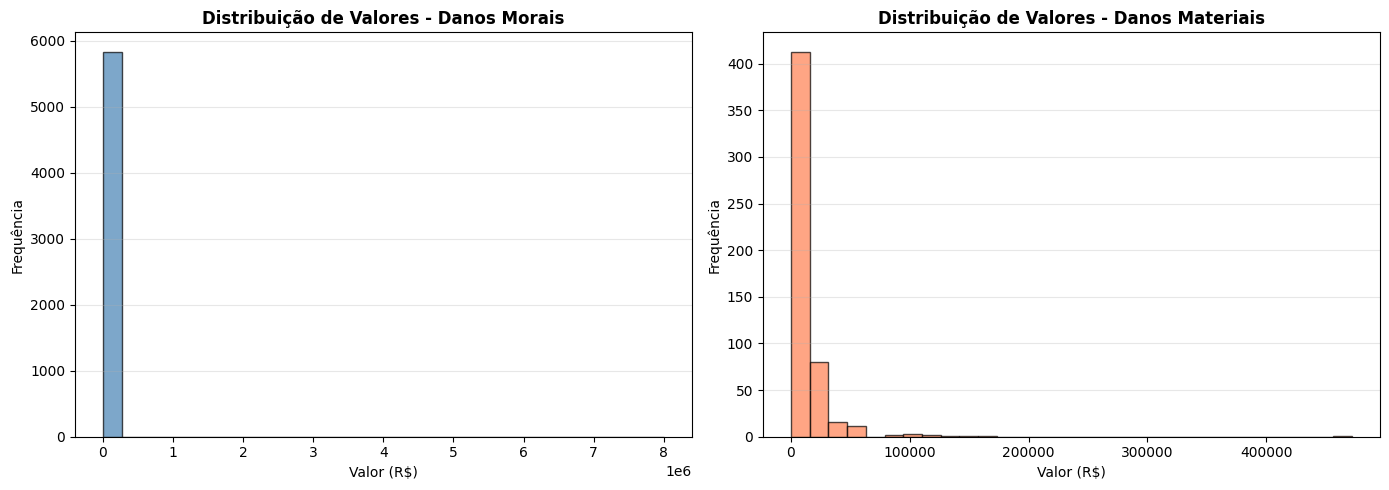

Gráfico salvo como 'histogramas_danos.png'


In [50]:
# Histogramas para valores de danos morais e materiais

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de Danos Morais
if len(df_moral) > 0:
    axes[0].hist(df_moral, bins=30, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].set_title('Distribuição de Valores - Danos Morais', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Valor (R$)', fontsize=10)
    axes[0].set_ylabel('Frequência', fontsize=10)
    axes[0].grid(axis='y', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Sem dados disponíveis', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Distribuição de Valores - Danos Morais', fontsize=12, fontweight='bold')

# Histograma de Danos Materiais
if len(df_material) > 0:
    axes[1].hist(df_material, bins=30, color='coral', edgecolor='black', alpha=0.7)
    axes[1].set_title('Distribuição de Valores - Danos Materiais', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Valor (R$)', fontsize=10)
    axes[1].set_ylabel('Frequência', fontsize=10)
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Sem dados disponíveis', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Distribuição de Valores - Danos Materiais', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('histogramas_danos.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfico salvo como 'histogramas_danos.png'")

/tmp/ipykernel_6821/2838118280.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tipo_vara', y='valor_moral', data=df_moral_box, ax=axes[0], palette='Set2')
/tmp/ipykernel_6821/2838118280.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='tipo_vara', y='valor_material', data=df_material_box, ax=axes[1], palette='Set1')


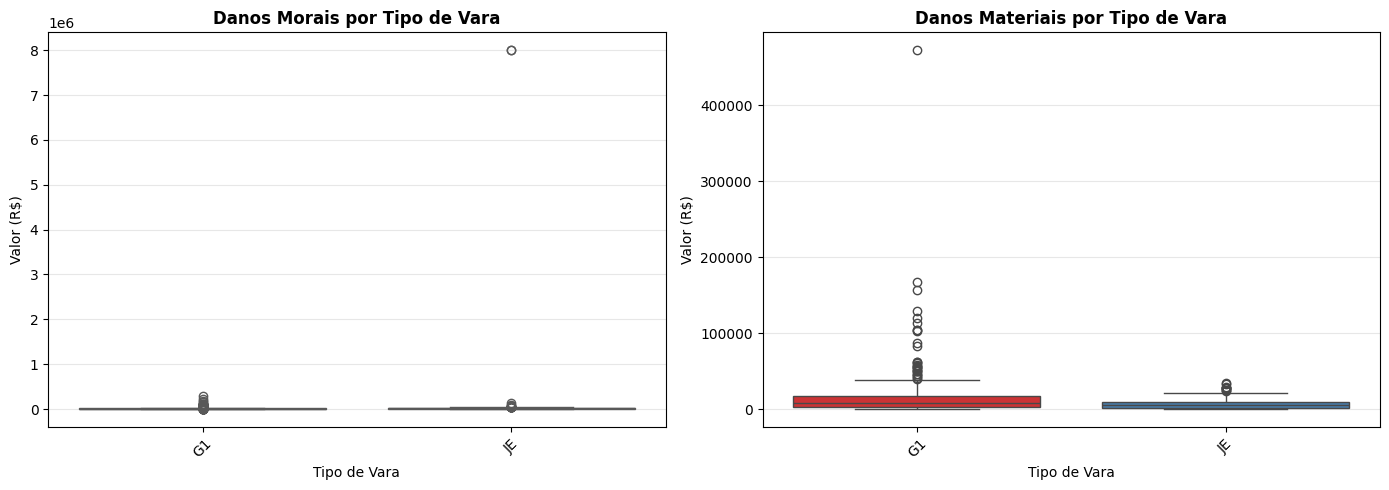

Gráfico salvo como 'boxplots_danos_vara.png'


In [51]:
# Boxplots de valores de danos por tipo de vara

import seaborn as sns

# Preparar dados para boxplot
df_boxplot = resultado_expandido[
    (resultado_expandido['valor_moral'] > 0) | (resultado_expandido['valor_material'] > 0)
][['tipo_vara', 'valor_moral', 'valor_material']].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Boxplot - Danos Morais por Tipo de Vara
df_moral_box = df_boxplot[df_boxplot['valor_moral'] > 0]
if len(df_moral_box) > 0:
    sns.boxplot(x='tipo_vara', y='valor_moral', data=df_moral_box, ax=axes[0], palette='Set2')
    axes[0].set_title('Danos Morais por Tipo de Vara', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Tipo de Vara', fontsize=10)
    axes[0].set_ylabel('Valor (R$)', fontsize=10)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y', alpha=0.3)
else:
    axes[0].text(0.5, 0.5, 'Sem dados disponíveis', ha='center', va='center', transform=axes[0].transAxes)
    axes[0].set_title('Danos Morais por Tipo de Vara', fontsize=12, fontweight='bold')

# Boxplot - Danos Materiais por Tipo de Vara
df_material_box = df_boxplot[df_boxplot['valor_material'] > 0]
if len(df_material_box) > 0:
    sns.boxplot(x='tipo_vara', y='valor_material', data=df_material_box, ax=axes[1], palette='Set1')
    axes[1].set_title('Danos Materiais por Tipo de Vara', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Tipo de Vara', fontsize=10)
    axes[1].set_ylabel('Valor (R$)', fontsize=10)
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)
else:
    axes[1].text(0.5, 0.5, 'Sem dados disponíveis', ha='center', va='center', transform=axes[1].transAxes)
    axes[1].set_title('Danos Materiais por Tipo de Vara', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('boxplots_danos_vara.png', dpi=150, bbox_inches='tight')
plt.show()

print("Gráfico salvo como 'boxplots_danos_vara.png'")

### Interpretação das Estatísticas

**Observações principais:**

- **Valores de Danos Morais**: A distribuição revela a variação típica de pedidos de indenização moral em processos de consignação de crédito, com mediana e média indicando o valor central esperado.

- **Valores de Danos Materiais**: Menos frequentes que danos morais, os valores materiais tendem a ser mais concentrados (menor desvio-padrão relativo) quando presentes.

- **Variação por Tipo de Vara**: Os boxplots mostram diferenças regionais e jurisdicionais nos valores pedidos, com algumas varas apresentando outliers significativos.

- **Presença de Flags**: A ocorrência de expressões como "não inferior a", "em dobro" ou "até" indica estratégias processuais diferenciadas, que podem correlacionar-se com os valores efetivamente deferidos.

## 12. Geração de Relatório Consolidado (relatorio.xlsx)

Este relatório consolida as análises em 3 abas:
- **Resumo**: métricas gerais do dataset
- **Descritivo**: estatísticas completas de valores
- **Logs/Sanidade**: verificações de qualidade dos dados

In [52]:
# IMPORTANTE: Execute seção 10.1 antes para ter resultado_expandido disponível

import openpyxl
from openpyxl import Workbook

# Prepara dados para o relatório
total_casos = len(resultado_expandido)
casos_com_moral = len(resultado_expandido[resultado_expandido['valor_moral'] > 0])
casos_com_material = len(resultado_expandido[resultado_expandido['valor_material'] > 0])

pct_moral = (casos_com_moral / total_casos * 100) if total_casos > 0 else 0
pct_material = (casos_com_material / total_casos * 100) if total_casos > 0 else 0

# Médias (apenas valores > 0)
media_moral = resultado_expandido[resultado_expandido['valor_moral'] > 0]['valor_moral'].mean()
media_material = resultado_expandido[resultado_expandido['valor_material'] > 0]['valor_material'].mean()

# Contagens por tipo_vara e uf
contagem_vara = resultado_expandido['tipo_vara'].value_counts().reset_index()
contagem_vara.columns = ['tipo_vara', 'contagem']

contagem_uf = resultado_expandido['uf'].value_counts().reset_index()
contagem_uf.columns = ['uf', 'contagem']

# ABA 1: RESUMO
aba_resumo = pd.DataFrame({
    'Métrica': [
        'Total de casos',
        '% com valor_moral > 0',
        '% com valor_material > 0',
        'Média valor_moral (>0)',
        'Média valor_material (>0)'
    ],
    'Valor': [
        total_casos,
        f'{pct_moral:.2f}%',
        f'{pct_material:.2f}%',
        f'R$ {media_moral:,.2f}' if not pd.isna(media_moral) else 'N/A',
        f'R$ {media_material:,.2f}' if not pd.isna(media_material) else 'N/A'
    ]
})

print("="*80)
print("RELATÓRIO - ABA RESUMO")
print("="*80)
display(aba_resumo)
print("\nContagem por Tipo de Vara:")
display(contagem_vara)
print("\nContagem por UF:")
display(contagem_uf)

RELATÓRIO - ABA RESUMO


,Métrica,Valor
0,Total de casos,8557
1,% com valor_moral > 0,68.27%
2,% com valor_material > 0,6.22%
3,Média valor_moral (>0),"R$ 16,685.57"
4,Média valor_material (>0),"R$ 13,201.19"



Contagem por Tipo de Vara:


,tipo_vara,contagem
0,G1,6847
1,JE,1710



Contagem por UF:


,uf,contagem
0,PI,1504
1,MA,1321
2,SP,1012
3,BA,682
4,CE,502
5,MG,435
6,AM,344
7,SC,334
8,AL,239
9,RJ,236


In [53]:
# ABA 2: DESCRITIVO (Estatísticas completas já calculadas na Seção 11)

print("="*80)
print("RELATÓRIO - ABA DESCRITIVO")
print("="*80)
print("\nEstatísticas de Danos Morais:")
display(stats_moral)
print("\nEstatísticas de Danos Materiais:")
display(stats_material)

RELATÓRIO - ABA DESCRITIVO

Estatísticas de Danos Morais:


,Métrica,Valor
0,count,5.842000e+03
1,mean,1.668557e+04
2,median,1.000000e+04
3,std,1.481645e+05
4,min,2.000000e+02
5,p25,1.000000e+04
6,p75,1.518000e+04
7,max,8.000000e+06



Estatísticas de Danos Materiais:


,Métrica,Valor
0,count,532.000000
1,mean,13201.191184
2,median,6259.400000
3,std,27338.597410
4,min,129.000000
5,p25,2304.600000
6,p75,15000.000000
7,max,472030.940000


In [54]:
# ABA 3: LOGS/SANIDADE

# Contagens de problemas de qualidade
cnpj_vazio = (resultado_expandido['cnpj'] == 'vazio').sum()
dt_vazia = (resultado_expandido['dt_distribuicao'] == '').sum()
sem_uf = (resultado_expandido['uf'] == '').sum()
sem_nome_empresa = (resultado_expandido['nome_empresa'] == '').sum()
valor_causa_zero = (resultado_expandido['valor_causa'] == 0).sum()

aba_logs = pd.DataFrame({
    'Indicador': [
        'CNPJ = "vazio"',
        'dt_distribuicao vazia',
        'UF vazia',
        'nome_empresa vazio',
        'valor_causa = 0',
        'Total de registros processados'
    ],
    'Contagem': [
        cnpj_vazio,
        dt_vazia,
        sem_uf,
        sem_nome_empresa,
        valor_causa_zero,
        total_casos
    ],
    'Percentual': [
        f'{(cnpj_vazio/total_casos*100):.2f}%' if total_casos > 0 else '0%',
        f'{(dt_vazia/total_casos*100):.2f}%' if total_casos > 0 else '0%',
        f'{(sem_uf/total_casos*100):.2f}%' if total_casos > 0 else '0%',
        f'{(sem_nome_empresa/total_casos*100):.2f}%' if total_casos > 0 else '0%',
        f'{(valor_causa_zero/total_casos*100):.2f}%' if total_casos > 0 else '0%',
        '100%'
    ]
})

print("="*80)
print("RELATÓRIO - ABA LOGS/SANIDADE")
print("="*80)
display(aba_logs)

RELATÓRIO - ABA LOGS/SANIDADE


,Indicador,Contagem,Percentual
0,"CNPJ = ""vazio""",816,9.54%
1,dt_distribuicao vazia,4043,47.25%
2,UF vazia,124,1.45%
3,nome_empresa vazio,0,0.00%
4,valor_causa = 0,35,0.41%
5,Total de registros processados,8557,100%


In [55]:
# Salvar relatorio.xlsx com 3 abas (aplicando limpeza de caracteres)

# Limpar dados antes de salvar no Excel
aba_resumo_limpo = aba_resumo.copy()
for col in aba_resumo_limpo.select_dtypes(include=['object']).columns:
    aba_resumo_limpo[col] = aba_resumo_limpo[col].apply(limpar_para_excel)

contagem_vara_limpo = contagem_vara.copy()
for col in contagem_vara_limpo.select_dtypes(include=['object']).columns:
    contagem_vara_limpo[col] = contagem_vara_limpo[col].apply(limpar_para_excel)

contagem_uf_limpo = contagem_uf.copy()
for col in contagem_uf_limpo.select_dtypes(include=['object']).columns:
    contagem_uf_limpo[col] = contagem_uf_limpo[col].apply(limpar_para_excel)

stats_moral_limpo = stats_moral.copy()
for col in stats_moral_limpo.select_dtypes(include=['object']).columns:
    stats_moral_limpo[col] = stats_moral_limpo[col].apply(limpar_para_excel)

stats_material_limpo = stats_material.copy()
for col in stats_material_limpo.select_dtypes(include=['object']).columns:
    stats_material_limpo[col] = stats_material_limpo[col].apply(limpar_para_excel)

aba_logs_limpo = aba_logs.copy()
for col in aba_logs_limpo.select_dtypes(include=['object']).columns:
    aba_logs_limpo[col] = aba_logs_limpo[col].apply(limpar_para_excel)

# Criar arquivo Excel com 3 abas
with pd.ExcelWriter('relatorio.xlsx', engine='openpyxl') as writer:
    # Aba 1: Resumo
    aba_resumo_limpo.to_excel(writer, sheet_name='Resumo', index=False, startrow=0)
    contagem_vara_limpo.to_excel(writer, sheet_name='Resumo', index=False, startrow=len(aba_resumo_limpo)+2)
    contagem_uf_limpo.to_excel(writer, sheet_name='Resumo', index=False, startrow=len(aba_resumo_limpo)+len(contagem_vara_limpo)+4)
    
    # Aba 2: Descritivo
    stats_moral_limpo.to_excel(writer, sheet_name='Descritivo', index=False, startrow=0)
    stats_material_limpo.to_excel(writer, sheet_name='Descritivo', index=False, startrow=len(stats_moral_limpo)+2)
    
    # Aba 3: Logs/Sanidade
    aba_logs_limpo.to_excel(writer, sheet_name='Logs_Sanidade', index=False)

print("\n" + "="*80)
print("✓ Arquivo 'relatorio.xlsx' criado com sucesso!")
print("  - Aba 'Resumo': métricas gerais + contagens")
print("  - Aba 'Descritivo': estatísticas completas de danos morais/materiais")
print("  - Aba 'Logs_Sanidade': verificações de qualidade dos dados")
print("="*80)


✓ Arquivo 'relatorio.xlsx' criado com sucesso!
  - Aba 'Resumo': métricas gerais + contagens
  - Aba 'Descritivo': estatísticas completas de danos morais/materiais
  - Aba 'Logs_Sanidade': verificações de qualidade dos dados


## 13. Sanidade Final e Verificação de Outputs

Esta seção verifica a integridade dos arquivos gerados e imprime um resumo final consolidado.

In [56]:
import os
from openpyxl import load_workbook

print("="*80)
print("VERIFICAÇÃO DE SANIDADE DOS OUTPUTS")
print("="*80)

# 1. Verificar output.xlsx (7 colunas da função original)
output_path = 'output.xlsx'
if os.path.exists(output_path):
    df_output = pd.read_excel(output_path)
    colunas_esperadas = ['cd_atendimento', 'nome_empresa', 'cnpj', 'valor_causa', 'dt_distribuicao', 'tipo_vara', 'uf']
    colunas_presentes = list(df_output.columns)
    
    print(f"\n✓ Arquivo '{output_path}' encontrado")
    print(f"  - Linhas: {len(df_output)}")
    print(f"  - Colunas: {colunas_presentes}")
    
    if colunas_presentes == colunas_esperadas:
        print("  ✓ Colunas corretas (7 colunas conforme roteiro)")
    else:
        print(f"  ✗ ATENÇÃO: Colunas diferentes do esperado!")
        print(f"    Esperado: {colunas_esperadas}")
        print(f"    Encontrado: {colunas_presentes}")
    
    # Verificar tipos
    print(f"\n  Tipagem de 'valor_causa': {df_output['valor_causa'].dtype}")
    if df_output['valor_causa'].dtype in ['float64', 'float32']:
        print("  ✓ valor_causa é float")
    else:
        print(f"  ✗ ATENÇÃO: valor_causa não é float!")
        
    # Verificar formato de data
    amostra_datas = df_output['dt_distribuicao'].dropna().head(3).tolist()
    print(f"  Amostra dt_distribuicao: {amostra_datas}")
    
else:
    print(f"\n✗ ERRO: Arquivo '{output_path}' NÃO encontrado!")
    print("  Execute a Seção 9 para gerar output.xlsx")

print("\n" + "-"*80)

# 2. Verificar relatorio.xlsx (3 abas)
relatorio_path = 'relatorio.xlsx'
if os.path.exists(relatorio_path):
    wb = load_workbook(relatorio_path)
    abas_presentes = wb.sheetnames
    abas_esperadas = ['Resumo', 'Descritivo', 'Logs_Sanidade']
    
    print(f"\n✓ Arquivo '{relatorio_path}' encontrado")
    print(f"  - Abas: {abas_presentes}")
    
    if set(abas_esperadas).issubset(set(abas_presentes)):
        print("  ✓ Todas as 3 abas esperadas estão presentes")
    else:
        print(f"  ✗ ATENÇÃO: Abas faltando!")
        print(f"    Esperado: {abas_esperadas}")
        
else:
    print(f"\n✗ ERRO: Arquivo '{relatorio_path}' NÃO encontrado!")
    print("  Execute a Seção 12 para gerar relatorio.xlsx")

print("\n" + "="*80)

VERIFICAÇÃO DE SANIDADE DOS OUTPUTS

✓ Arquivo 'output.xlsx' encontrado
  - Linhas: 8557
  - Colunas: ['cd_atendimento', 'nome_empresa', 'cnpj', 'valor_causa', 'dt_distribuicao', 'tipo_vara', 'uf']
  ✓ Colunas corretas (7 colunas conforme roteiro)

  Tipagem de 'valor_causa': float64
  ✓ valor_causa é float
  Amostra dt_distribuicao: ['2025-02-07', '2025-04-10', '2025-06-12']

--------------------------------------------------------------------------------

✓ Arquivo 'relatorio.xlsx' encontrado
  - Abas: ['Resumo', 'Descritivo', 'Logs_Sanidade']
  ✓ Todas as 3 abas esperadas estão presentes


✓ Arquivo 'output.xlsx' encontrado
  - Linhas: 8557
  - Colunas: ['cd_atendimento', 'nome_empresa', 'cnpj', 'valor_causa', 'dt_distribuicao', 'tipo_vara', 'uf']
  ✓ Colunas corretas (7 colunas conforme roteiro)

  Tipagem de 'valor_causa': float64
  ✓ valor_causa é float
  Amostra dt_distribuicao: ['2025-02-07', '2025-04-10', '2025-06-12']

---------------------------------------------------------

In [57]:
# RESUMO FINAL CONSOLIDADO

print("="*80)
print("RESUMO FINAL DO PROCESSAMENTO")
print("="*80)

# Usar resultado_expandido se disponível, senão tentar ler de output.xlsx
try:
    df_final = resultado_expandido
    print("\n[Dados de resultado_expandido]")
except NameError:
    if os.path.exists('output.xlsx'):
        df_final = pd.read_excel('output.xlsx')
        print("\n[Dados de output.xlsx]")
    else:
        print("\n✗ ERRO: Nenhum dataset disponível para resumo!")
        df_final = None

if df_final is not None:
    print(f"\n📊 Total de linhas processadas: {len(df_final)}")
    
    # CNPJ vazio
    cnpj_vazio_count = (df_final['cnpj'] == 'vazio').sum()
    print(f"\n🔑 CNPJs:")
    print(f"   - CNPJ = 'vazio': {cnpj_vazio_count} ({cnpj_vazio_count/len(df_final)*100:.2f}%)")
    print(f"   - CNPJ válido: {len(df_final) - cnpj_vazio_count} ({(len(df_final)-cnpj_vazio_count)/len(df_final)*100:.2f}%)")
    
    # Datas vazias
    datas_vazias = (df_final['dt_distribuicao'] == '').sum()
    print(f"\n📅 Datas de Distribuição:")
    print(f"   - Vazias: {datas_vazias} ({datas_vazias/len(df_final)*100:.2f}%)")
    print(f"   - Preenchidas: {len(df_final) - datas_vazias} ({(len(df_final)-datas_vazias)/len(df_final)*100:.2f}%)")
    
    # Médias de valores (se disponível no df_final)
    if 'valor_moral' in df_final.columns and 'valor_material' in df_final.columns:
        moral_positivos = df_final[df_final['valor_moral'] > 0]['valor_moral']
        material_positivos = df_final[df_final['valor_material'] > 0]['valor_material']
        
        print(f"\n💰 Valores Médios (apenas > 0):")
        if len(moral_positivos) > 0:
            print(f"   - Danos Morais: R$ {moral_positivos.mean():,.2f} ({len(moral_positivos)} casos)")
        else:
            print(f"   - Danos Morais: N/A (nenhum caso com valor > 0)")
            
        if len(material_positivos) > 0:
            print(f"   - Danos Materiais: R$ {material_positivos.mean():,.2f} ({len(material_positivos)} casos)")
        else:
            print(f"   - Danos Materiais: N/A (nenhum caso com valor > 0)")
    
    # Valor causa
    if 'valor_causa' in df_final.columns:
        valor_causa_positivos = df_final[df_final['valor_causa'] > 0]['valor_causa']
        print(f"\n⚖️  Valor da Causa:")
        if len(valor_causa_positivos) > 0:
            print(f"   - Média: R$ {valor_causa_positivos.mean():,.2f}")
            print(f"   - Casos com valor > 0: {len(valor_causa_positivos)} ({len(valor_causa_positivos)/len(df_final)*100:.2f}%)")
        else:
            print(f"   - Nenhum caso com valor_causa > 0")

print("\n" + "="*80)
print("✓ PROCESSAMENTO CONCLUÍDO COM SUCESSO")
print("="*80)

RESUMO FINAL DO PROCESSAMENTO

[Dados de resultado_expandido]

📊 Total de linhas processadas: 8557

🔑 CNPJs:
   - CNPJ = 'vazio': 816 (9.54%)
   - CNPJ válido: 7741 (90.46%)

📅 Datas de Distribuição:
   - Vazias: 4043 (47.25%)
   - Preenchidas: 4514 (52.75%)

💰 Valores Médios (apenas > 0):
   - Danos Morais: R$ 16,685.57 (5842 casos)
   - Danos Materiais: R$ 13,201.19 (532 casos)

⚖️  Valor da Causa:
   - Média: R$ 18,444.90
   - Casos com valor > 0: 8522 (99.59%)

✓ PROCESSAMENTO CONCLUÍDO COM SUCESSO
